In [4]:
pip install pandas_datareader

Note: you may need to restart the kernel to use updated packages.


In [163]:
import pandas_datareader as pdr
import pandas as pd 
key = '1e9dd563cc22287463f26ece575a87e2ea974ce6'
#import external pandas_datareader library with alias of web
import pandas_datareader as web
import datetime

# define the time frame of the data

start = datetime.datetime(2005, 9, 1)
end = datetime.datetime(2020, 6, 18)
 
#DataReader method name is case sensitive
df = web.DataReader("^GDAXI",'yahoo', start, end)

df.to_csv('DAX30.csv')

data = pd.read_csv('DAX30.csv',date_parser = True)
data.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
3744,2020-06-12,12172.629883,11828.660156,11876.339844,11949.280273,118016300.0,11949.280273
3745,2020-06-15,11968.059570,11597.820312,11661.360352,11911.349609,99879200.0,11911.349609
3746,2020-06-16,12434.269531,12132.799805,12168.370117,12315.660156,122780400.0,12315.660156
3747,2020-06-17,12432.230469,12288.169922,12312.440430,12382.139648,102040400.0,12382.139648
3748,2020-06-18,12483.839844,12189.669922,12347.490234,12281.530273,154821700.0,12281.530273


In [164]:
# now we want to add other variables to the csv in order to give the LSTM network more data to process 



In [165]:
df1 = df.reset_index()['Close'] #focus on close price 
df1.head()

0    4842.939941
1    4837.810059
2    4909.890137
3    4968.279785
4    4988.140137
Name: Close, dtype: float64

In [166]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler 
scaler = MinMaxScaler(feature_range = (0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [167]:
#splitting data into train and test 
training_size = int(len(df1)*0.65)
test_size = len(df1)-training_size
train_data, test_data = df1[0:training_size,:], df1[training_size:len(df1),:1]

In [168]:
import numpy
# transorm array into a matrix 
def create_dataset(dataset,time_steps=1):
    dataX, dataY = [],[]
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step),0]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
        
    return  numpy.array(dataX), numpy.array(dataY)

In [169]:
# reshape into X = t, t+1, t+2, t+3 and Y=t+4 
time_step = 100 
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [170]:
print(X_train)

[[0.11622816 0.11572139 0.1228421  ... 0.1772027  0.17082584 0.17430617]
 [0.11572139 0.1228421  0.12861035 ... 0.17082584 0.17430617 0.16622328]
 [0.1228421  0.12861035 0.13057234 ... 0.17430617 0.16622328 0.16619366]
 ...
 [0.54334511 0.55806572 0.56418369 ... 0.80782386 0.81025904 0.83176339]
 [0.55806572 0.56418369 0.55572933 ... 0.81025904 0.83176339 0.81992454]
 [0.56418369 0.55572933 0.56166062 ... 0.83176339 0.81992454 0.82340289]]


In [171]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [172]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [173]:

model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1)))
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 100, 50)           10400     
_________________________________________________________________
lstm_13 (LSTM)               (None, 100, 50)           20200     
_________________________________________________________________
lstm_14 (LSTM)               (None, 50)                20200     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [174]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)


Epoch 1/100
37/37 [==============================] - 4s 116ms/step - loss: 0.0148 - val_loss: 0.0023
Epoch 2/100
37/37 [==============================] - 4s 101ms/step - loss: 8.9116e-04 - val_loss: 0.0034
Epoch 3/100
37/37 [==============================] - 4s 101ms/step - loss: 7.0975e-04 - val_loss: 0.0026
Epoch 4/100
37/37 [==============================] - 4s 103ms/step - loss: 6.8648e-04 - val_loss: 0.0022
Epoch 5/100
37/37 [==============================] - 4s 102ms/step - loss: 6.6004e-04 - val_loss: 0.0025
Epoch 6/100
37/37 [==============================] - 4s 101ms/step - loss: 6.4637e-04 - val_loss: 0.0018
Epoch 7/100
37/37 [==============================] - 4s 101ms/step - loss: 6.3535e-04 - val_loss: 0.0018
Epoch 8/100
37/37 [==============================] - 4s 102ms/step - loss: 6.1431e-04 - val_loss: 0.0021
Epoch 9/100
37/37 [==============================] - 4s 100ms/step - loss: 5.4388e-04 - val_loss: 0.0015
Epoch 10/100
37/37 [==============================] - 4s 10

In [175]:
import tensorflow as tf

tf.__version__

'2.2.0'

In [176]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [177]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)


In [178]:

### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

7160.6201473606625

In [179]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

11760.666680206214

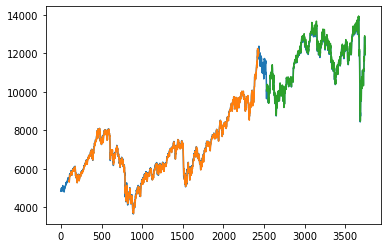

In [180]:

import matplotlib.pyplot as plt
### Plotting 
# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [181]:

n0 = len(test_data)


In [182]:

n1 = n0 - time_step
x_input=test_data[n1:].reshape(1,-1)
x_input.shape

(1, 100)

In [183]:

temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [184]:
temp_input

[0.9422844880927363,
 0.954032558241281,
 0.9561377082204341,
 0.9375772527262167,
 0.9202743303413099,
 0.9265198369336027,
 0.9498883426849596,
 0.9693092460350987,
 0.9788414145351774,
 0.9728142276533847,
 0.9708602517733713,
 0.9840791581155903,
 0.9961255245720739,
 0.9956957347752211,
 0.9955752392743749,
 0.9994951537582646,
 0.9893496062394673,
 1.0,
 0.987651381818816,
 0.9792869295254953,
 0.9255368676316647,
 0.9013582732329062,
 0.8998161430639513,
 0.8595675586268134,
 0.8124343301329269,
 0.8092257153509894,
 0.821823235367388,
 0.8358809794837114,
 0.8178054966738442,
 0.778008408588956,
 0.6874337060694593,
 0.6726618645173768,
 0.6690253894101772,
 0.5428175914459192,
 0.5498266864202752,
 0.5014368895528737,
 0.5208834548751705,
 0.47174685602854594,
 0.48841449989217867,
 0.5198808049630061,
 0.501328260302311,
 0.5961083426275577,
 0.6132669405374722,
 0.6257835192206362,
 0.5893856777108576,
 0.6075085290482792,
 0.619350371516137,
 0.5807150182760755,
 0.58329047

In [185]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    



[0.850509]
101
1 day input [0.95403256 0.95613771 0.93757725 0.92027433 0.92651984 0.94988834
 0.96930925 0.97884141 0.97281423 0.97086025 0.98407916 0.99612552
 0.99569573 0.99557524 0.99949515 0.98934961 1.         0.98765138
 0.97928693 0.92553687 0.90135827 0.89981614 0.85956756 0.81243433
 0.80922572 0.82182324 0.83588098 0.8178055  0.77800841 0.68743371
 0.67266186 0.66902539 0.54281759 0.54982669 0.50143689 0.52088345
 0.47174686 0.4884145  0.5198808  0.50132826 0.59610834 0.61326694
 0.62578352 0.58938568 0.60750853 0.61935037 0.58071502 0.58329048
 0.57883996 0.63311464 0.66092672 0.6585745  0.68147878 0.69450107
 0.65332586 0.65547751 0.68750886 0.69246017 0.65037107 0.66668909
 0.67644546 0.65889065 0.69088842 0.70428812 0.73512118 0.71080916
 0.67180335 0.69775127 0.68557456 0.70069612 0.71504136 0.7071886
 0.70664623 0.67929751 0.65898249 0.67164233 0.73029335 0.73191545
 0.7465777  0.73099076 0.73177518 0.7631318  0.77433151 0.78945018
 0.80164463 0.78245189 0.82536883 0.

In [186]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)


In [187]:
n2 = len(df1)

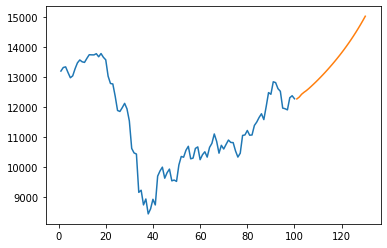

In [188]:
n3 = n2 - time_step
plt.plot(day_new,scaler.inverse_transform(df1[n3:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

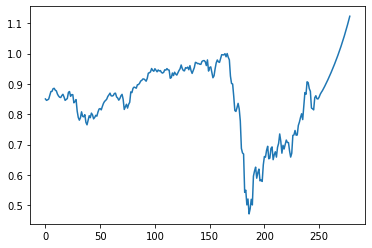

In [189]:

df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[3500:])

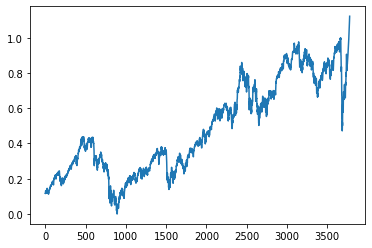

In [190]:
plt.plot(df3)